# Lineal logistic regression

## Bild Logistic regression implementation in Numpy
 

### Import Packages and data

In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import scikitplot as skplt
import math


In [53]:
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import classification_report
from IPython.core.interactiveshell import InteractiveShell


In [54]:
warnings.filterwarnings('ignore')
InteractiveShell.ast_node_interactivity = "all"
data_1 = "C:\\Users\\fourz\\OneDrive\\Рабочий стол\\Статистика\\классификация\\Logistic regression all methods\\data for log.txt"
data_2 = "C:\\Users\\fourz\\OneDrive\\Рабочий стол\\Статистика\\классификация\\Logistic regression all methods\\DATA for log2.txt"


In [55]:
df = pd.read_csv(data_1, names=["X1", "X2", "Y"])
df.head()


,X1,X2,Y
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


In [103]:
X_train = df.iloc[:, :-1].values
y_train = df.Y.values


### Визуализация данных

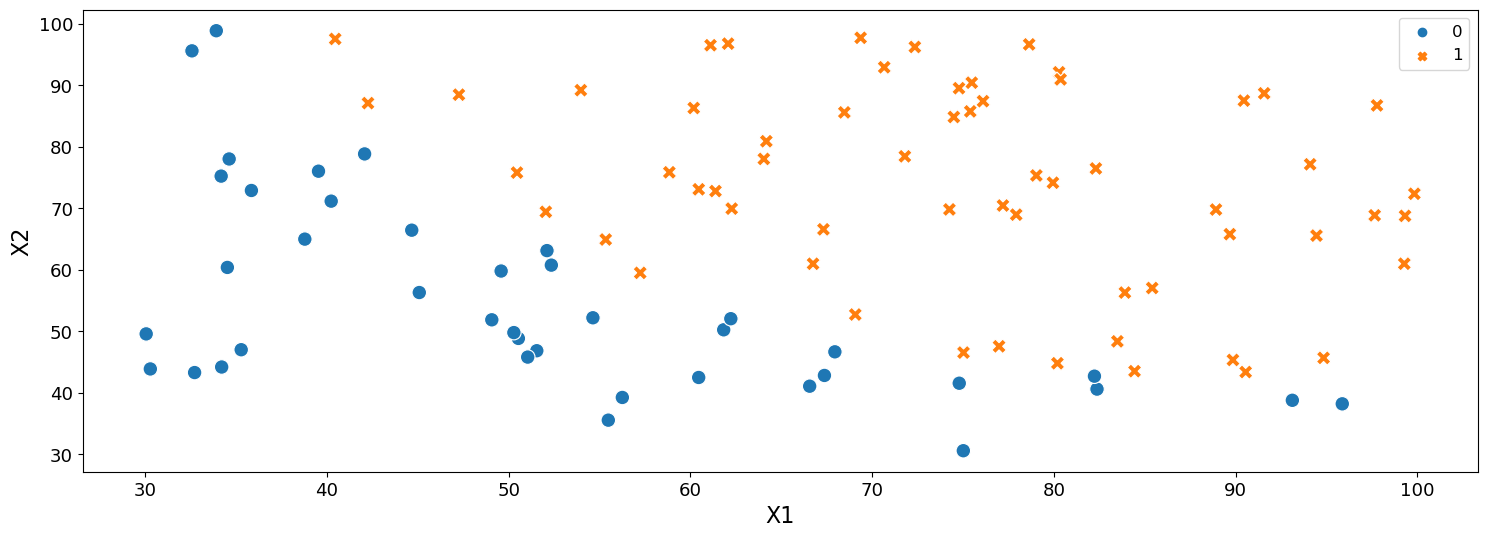

In [106]:
plt.figure(figsize=(18, 6))
sns.scatterplot(
    x="X1", 
    y="X2", 
    data=df,
    hue="Y", 
    s=110,
    style="Y"
)
plt.tick_params(labelsize=13)
plt.ylabel("X2", fontsize=16)
plt.xlabel("X1", fontsize=16)
plt.legend(fontsize=12);

### Расчет сигмоидальной функции


In [107]:
def sigmoid(z) -> float:
    """
    Вычислить сигмойдную функцию 

    Args:
        z (ndarray): скаляр значений (w * X + b).

    Returns:
        g (ndarray): sigmoid(z)
    """
    g = 1 / (1 + np.exp(-z))
    return g

print ("sigmoid(0) = " + str(sigmoid(0)))  

sigmoid(0) = 0.5


### Фукнкция потерть log loss 

In [59]:
def compute_cost_function(x, y, w, b, lambda_= None) -> float:
    '''
    Cначала объявляем параметры для нашей функции 
    
    Args:
        x (ndarray (m,n)): данные где "m" == X.shape[0], a "n" == X.shape[1]
        y (ndarray (m,)) : целевая переменная 
        w (ndarray (n,)) : параметр наклона или зависимый член функции 
        b (scalar)       : параметр перехвата или независимый член функции
      
    Returns:
        total_cost
        
    '''
    m = x.shape[0]
    cost = 0.0
    
    
    for i in range(m):
        Z_i = np.dot(x[i], w) + b
        G_z = sigmoid(Z_i)
        cost += -y[i] * np.log(G_z) - (1 - y[i]) * np.log(1 - G_z)
        
    total_cost = (1 / m) * cost
        
    return total_cost


#### Результат работы функции "compute_cost_function"

In [60]:
m, n = X_train.shape
initial_w = np.zeros(n)
initial_b = 0.0
cost = compute_cost_function(X_train, y_train, initial_w, initial_b)
print('Функция с нулевыми весами: {:.3f}'.format(cost))

Функция с нулевыми весами: 0.693


### Расчет градиента для функции потерь log loss

In [61]:
def compute_gradient(x, y, w, b, lambda_ = None) -> tuple([float, float]):
    """
    Вычисляет градиент для логистической регрессии 
 
    Args:
      x : (ndarray (m,n))    данные где "m" == X.shape[0], a "n" == X.shape[1] 
      y : (ndarray (m,1))    целевая переменная 
      w : (ndarray (n,1))    параметр наклона или зависимый член функции       
      b : (scalar)           параметр перехвата или независимый член функции
      
      
    Returns
      derivative_w: (ndarray (n,1)) Градиент параметра w 
      derivative_b: (scalar)        Градиент параметра b 
      
    """
    m, n = x.shape
    derivative_w = np.zeros(w.shape)
    derivative_b = 0.0
    
    for i in range(m):
        z = np.dot(x[i], w) + b
        G_z = sigmoid(z)
        error = G_z - y[i]
        
        
        for j in range(n):
            derivative_w[j] = derivative_w[j] + error * x[i, j] 
            
            
        derivative_b = derivative_b + error
        
    derivative_w = derivative_w / m
    derivative_b = derivative_b / m
    
    return derivative_b, derivative_w
        

### Проверка расчета градиента со случайными параметрами


In [62]:
initial_w = np.zeros(n)
initial_b = 0.0


derivative_B, derivative_W = compute_gradient(
    X_train, y_train,
    initial_w,
    initial_b
)


print(f'Градиент по смещению при начальных весах (нули):{derivative_B}' )
print(f'Градиент по весам при начальных весах (нули):{derivative_W.tolist()}' )

Градиент по смещению при начальных весах (нули):-0.1
Градиент по весам при начальных весах (нули):[-12.00921658929115, -11.262842205513591]


### Расчет пакетного градиентного спуска с регуляризацией

In [63]:
def gradient_descent(
        x, y, w, b, 
        cost_function, 
        gradient_function, 
        alpha, 
        num_iters, 
        lambda_
      ) -> tuple([float, float, list[float], list[float]]): 
    """
   Выполняет пакетный градиентный спуск используя регулирезацию Ridge. Пошагово обновляет веса функции,
   с альфа-скоростью обучени
    
    Args:
      x : (ndarray (m,n))    данные где "m" == X.shape[0], a "n" == X.shape[1] 
      y : (ndarray (m,1))    целевая переменная 
      w : (ndarray (n,1))    параметр наклона или зависимый член функции       
      b : (scalar)           параметр перехвата или независимый член функции
      
      cost_function:         функция потерь
      alpha :                Скорость обучения или шаг
      num_iters :            кол-во итераций для градиентного спуска
      lambda_ :              регуляризация константа
      
    Returns:
      w : подогнанный параметр наклона с помощью грудиентного спуска 
      b : подобранный параметр перехвата с помощью градиентного спуска
    """
    J_histoty = list()
    W_histoty = list()
    
    m, n = x.shape
    
    for i in range(num_iters):
        derivative_b, derivative_w = gradient_function(x, y, w, b, lambda_)
        
        w = w - alpha * derivative_w
        b = b - alpha * derivative_b
        
        
        if i < 100000:
            cost = cost_function(x, y, w, b, lambda_)
            J_histoty.append(cost)
        
        
        if i % math.ceil(num_iters / 10) == 0 or i == (num_iters - 1):
            W_histoty.append(w)
            print(f"Iteration {i:4}: Cost {float(J_histoty[-1]):8.2f}")
        
    return w, b, J_histoty, W_histoty
    
    

#### Обучение модели 

In [64]:
np.random.seed(1234)

intial_w = 0.01 * (np.random.rand(2).reshape(-1, 1) - 0.5)
initial_b = -8
iterations = 1000
alpha = 0.001

w, b, J_history,_ = gradient_descent(
    X_train, 
    y_train, 
    initial_w, 
    initial_b, 
    compute_cost_function,
    compute_gradient, 
    alpha, 
    iterations, 
    0
)

Iteration    0: Cost     1.01
Iteration  100: Cost     0.31
Iteration  200: Cost     0.31
Iteration  300: Cost     0.31
Iteration  400: Cost     0.31


Iteration  500: Cost     0.31
Iteration  600: Cost     0.31
Iteration  700: Cost     0.31
Iteration  800: Cost     0.31
Iteration  900: Cost     0.31
Iteration  999: Cost     0.31


### Визуализация потерь

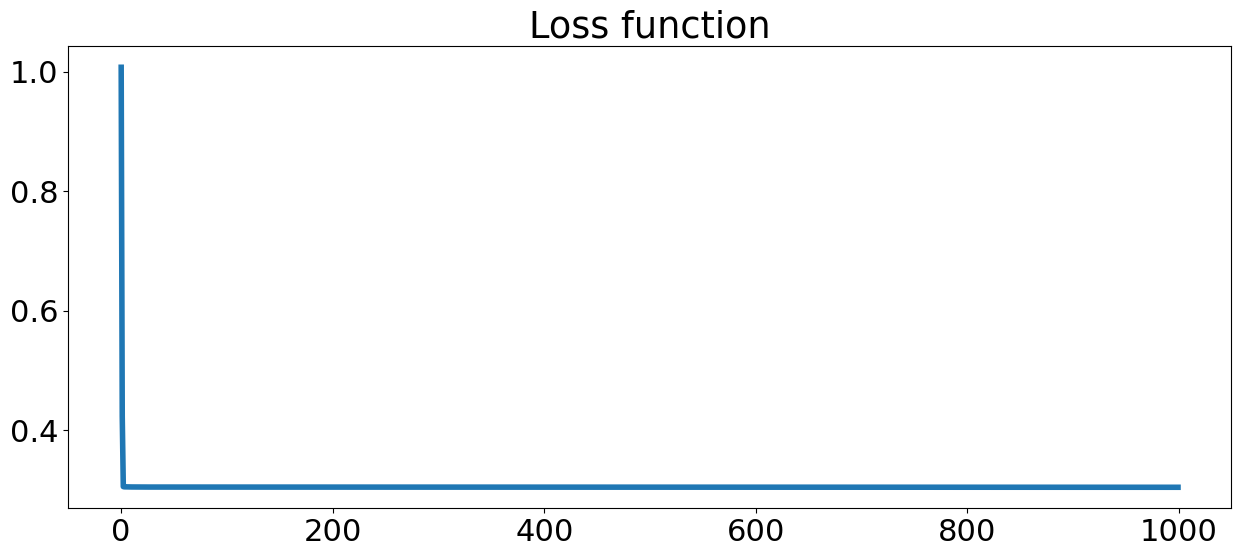

In [65]:
plt.subplots(figsize=(15, 6))
plt.plot(J_history, label='Loss function', linewidth = 4)
plt.title("Loss function");

### Визуализация результата

In [122]:
def decision_boundary(w, b, X, y) -> None:
    """
    Строит границу между классами
    
    Args:
      x : (ndarray (m,n))    данные где "m" == X.shape[0], a "n" == X.shape[1] 
      y : (ndarray (m,1))    целевая переменная 
      w : (ndarray (n,1))    параметр наклона или зависимый член функции       
      b : (scalar)           параметр перехвата или независимый член функции
      
    Returns: 
      None
    """
    
    if X.shape[1] <= 2:
        plot_x = np.array([min(X[:, 0]), max(X[:, 0])])
        plot_y = (-1. / w[1]) * (w[0] * plot_x + b)
        plt.plot(plot_x, plot_y, c="r", linewidth=3)
    
    return None
   

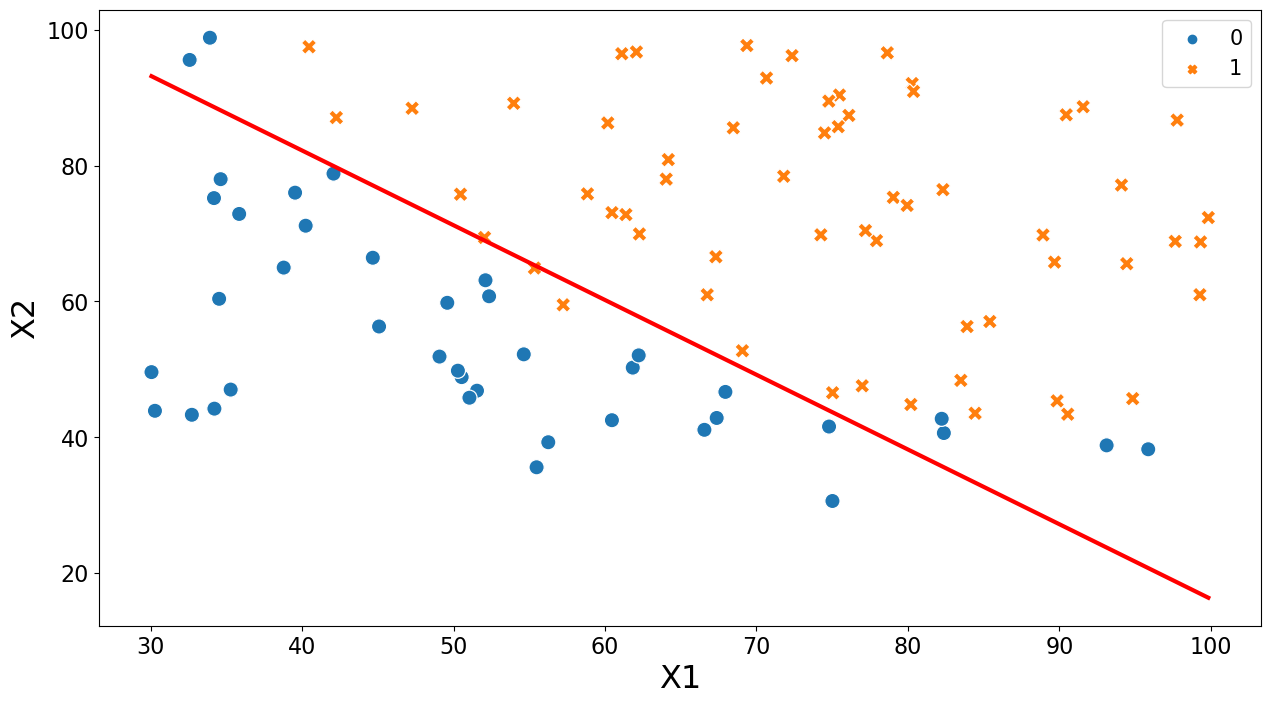

In [123]:
plt.figure(figsize=(15, 8))

sns.scatterplot(
    x="X1", 
    y="X2", 
    data=df,
    hue="Y", 
    s=120, 
    style="Y"
)

decision_boundary(w, b, X_train, y_train)

plt.tick_params(labelsize = 16)
plt.ylabel("X2", fontsize = 23)
plt.xlabel("X1", fontsize = 23)
plt.legend(fontsize = 15);

### предсказания модели

In [108]:
def predicted_p(X, w, b) -> np.array([int]): 
    """
    Предсказать, будет ли метка равна 0 или 1, используя изученные
    параметры логистической регрессии w, b
    
    Args:
        X : (ndarray (m, n))       Данные где "m" == X.shape[0], a "n" == X.shape[1] 
        w : (ndarray (n,))         Параметр наклона или зависимый член функции
        b : (scalar, float)        Параметр перехвата или независимый член функции

    Returns:
        p: (ndarray (m,1))         Прогнозы для X с использованием порога в 0,5
    """
    m, n = X.shape   
    probability = np.zeros(m)
    
    for i in range(m):
        z = np.dot(X[i], w) + b
        G_z = sigmoid(z)
        
        if G_z > 0.5:
            probability[i] = 1
            
        else:
            probability[i] = 0
    
    return probability  

#### Тестирование предсказаний

In [109]:
np.random.seed(1234)

tmp_w = np.random.randn(2)
tmp_b = 0.3    
tmp_X = np.random.randn(10, 2) 

tmp_p = predicted_p(tmp_X, tmp_w, tmp_b)

print(f'Предсказания: shape {tmp_p.shape}, value {tmp_p}')

Предсказания: shape (10,), value [1. 0. 1. 1. 0. 1. 1. 1. 1. 1.]


### Metrics

In [70]:
p = predicted_p(X_train, w, b)
print("\n",  "**" * 38,  "\n")
print("Accuracy: %f" %(np.mean(p == y_train) * 100))
print("\n",  "**" * 38,  "\n")
print(classification_report(y_train, p))
print("\n",  "**" * 38,  "\n")


 **************************************************************************** 

Accuracy: 92.000000

 **************************************************************************** 

              precision    recall  f1-score   support

           0       0.94      0.85      0.89        40
           1       0.91      0.97      0.94        60

    accuracy                           0.92       100
   macro avg       0.93      0.91      0.92       100
weighted avg       0.92      0.92      0.92       100


 **************************************************************************** 



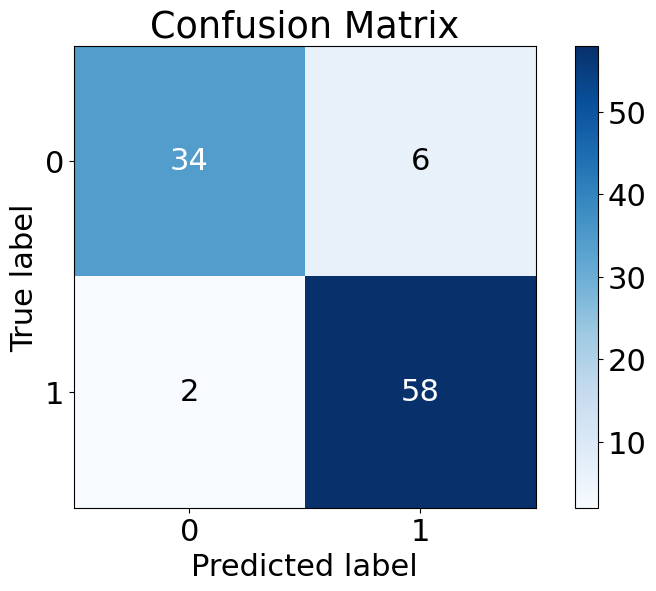

In [71]:
skplt.metrics.plot_confusion_matrix(
    y_train,
    p,
    figsize = (10, 6),
)
plt.show();

## Логистическая регрессия scikit-learn

### создание логистической регресиии с помощью scikit-learn

In [72]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X_train, y_train, test_size= .2, random_state = 1234)

In [73]:
Logistic_model = LogisticRegression()
Logistic_model.fit(X1_train, y1_train)
y_pred = Logistic_model.predict(X1_test)

LogisticRegression()

###  Metric

In [74]:
print("\n",  "**" * 38,  "\n")
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(Logistic_model.score(X1_test, y1_test) * 100))
print("\n",  "**" * 38,  "\n")
print(classification_report(y1_test, y_pred))
print("\n",  "**" * 38,  "\n")



 **************************************************************************** 

Accuracy of logistic regression classifier on test set: 85.00

 **************************************************************************** 

              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.92      0.86      0.89        14

    accuracy                           0.85        20
   macro avg       0.82      0.85      0.83        20
weighted avg       0.86      0.85      0.85        20


 **************************************************************************** 



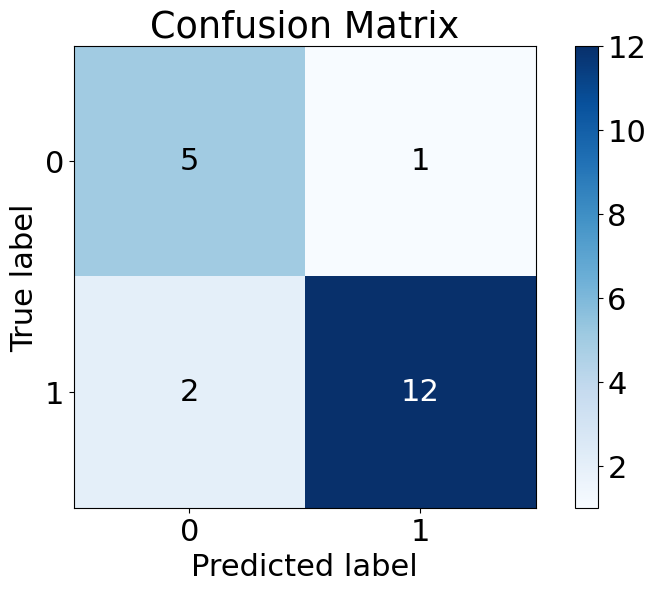

In [75]:
skplt.metrics.plot_confusion_matrix(
    y1_test,
    y_pred,
    figsize=(10, 6),
)
plt.show();

### Plot AUC-ROC Curve

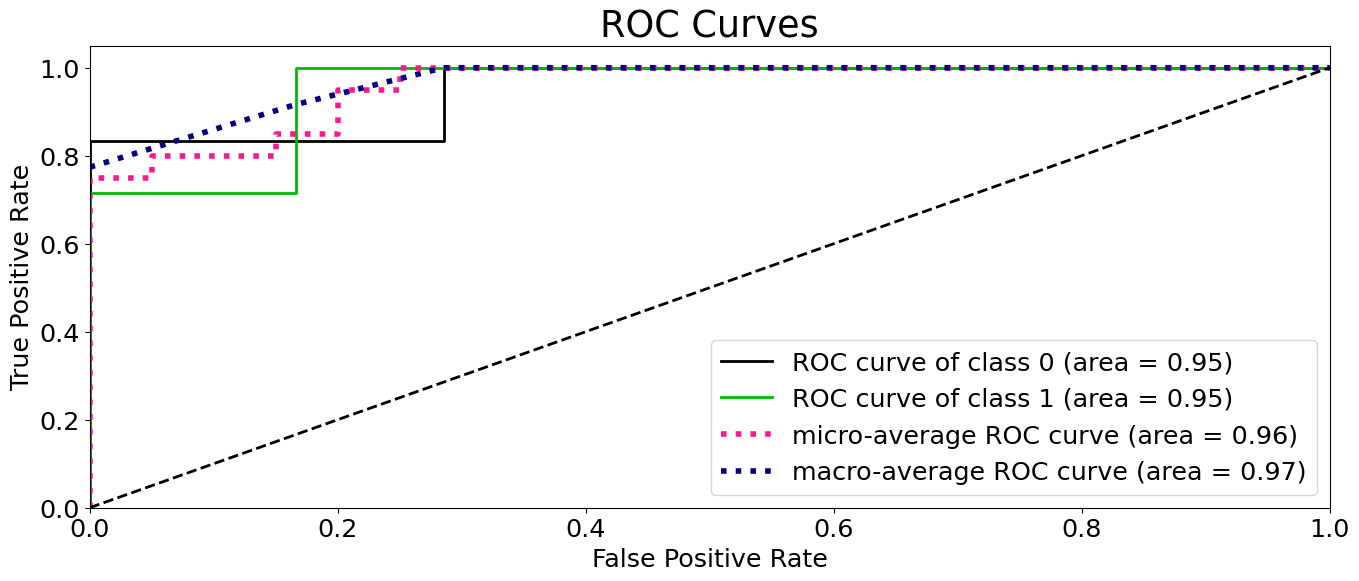

In [110]:
y_true = y1_test
y_probas = Logistic_model.predict_proba(X1_test)
skplt.metrics.plot_roc_curve(
    y1_test,
    y_probas,
    title_fontsize='large',
    figsize = (16, 6),
    text_fontsize = "small"
)
plt.show();

### Построение границы принятия решений 

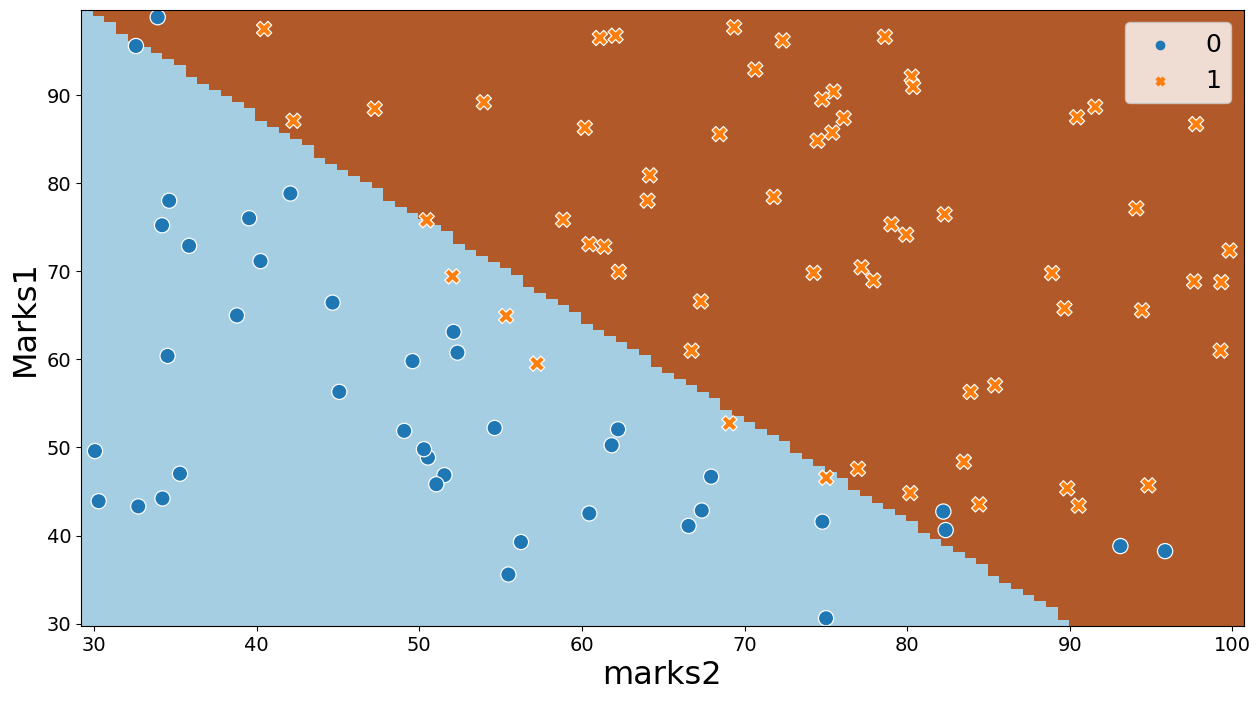

In [77]:
_, ax = plt.subplots(figsize=(15, 8))
DecisionBoundaryDisplay.from_estimator(
    Logistic_model,
    X_train,
    ax = ax,
    cmap=plt.cm.Paired,
    response_method="predict",
    plot_method="pcolormesh",
    shading="auto",
    xlabel="marks1",
    ylabel="marks2",
    eps=0.5,
)
sns.scatterplot(
    x="X1",
    y="X2",
    data=df,
    hue="Y",
    s=120,
    style="Y",
)
plt.tick_params(labelsize=14)
plt.ylabel("Marks1", fontsize=23)
plt.xlabel("marks2", fontsize=23)
plt.legend(fontsize=18);

---

# Полиномиальная логистическая регрессия

## Полиномиальная логистическая регрессия с регуляризацией гребня Numpy


In [101]:
df2 = pd.read_csv(data_2, names=["estimation1", "estimation2", "Y"])
df2.describe()

,estimation1,estimation2,Y
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646563,1.000000
max,1.070900,1.108900,1.000000


In [79]:
XX_train = df2.iloc[:, :-1].values
yy_train = df2.Y.values

### Plot data

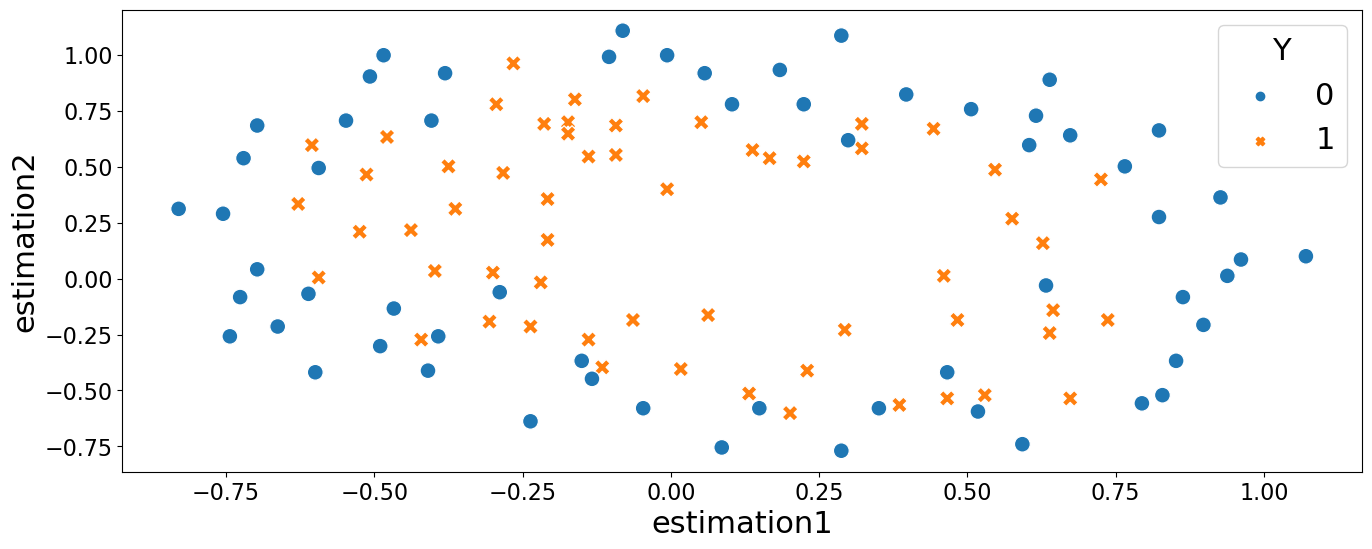

In [124]:
plt.figure(figsize=(16, 6))
sns.scatterplot(
    x="estimation1",
    y="estimation2",
    hue="Y",
    data=df2,
    s=130,
    style="Y"
)

plt.tick_params(labelsize=16);

### Создание полинома 6-ой степени

In [81]:
def map_feature(X1, X2):
    """
    Создание полинома 6-ой степени
    
    Args:
      x1 : (ndarray (m,n))       независемая переменная 
      x2 : (ndarray (m,n))       независемая переменная  
            
    Returns:
      vector : (ndarray (m, 1))  веса для нашей функции 
    
    """
    X1 = np.atleast_1d(X1)
    X2 = np.atleast_1d(X2)
    degree = 6
    out = []
    
    for i in range(1, degree + 1):
        for j in range(i + 1):
            out.append((X1 ** (i - j) * (X2 ** j)))
            
    return np.stack(out, axis=1)

In [82]:
mapped_X = map_feature(XX_train[:, 0], XX_train[:, 1])
mapped_X.shape

(118, 27)

In [83]:
XX_train[0]
mapped_X[0]

array([0.051267, 0.69956 ])

array([5.12670000e-02, 6.99560000e-01, 2.62830529e-03, 3.58643425e-02,
       4.89384194e-01, 1.34745327e-04, 1.83865725e-03, 2.50892595e-02,
       3.42353606e-01, 6.90798869e-06, 9.42624411e-05, 1.28625106e-03,
       1.75514423e-02, 2.39496889e-01, 3.54151856e-07, 4.83255257e-06,
       6.59422333e-05, 8.99809795e-04, 1.22782870e-02, 1.67542444e-01,
       1.81563032e-08, 2.47750473e-07, 3.38066048e-06, 4.61305487e-05,
       6.29470940e-04, 8.58939846e-03, 1.17205992e-01])

### Функция потерь с регуляризацией Ridge

In [111]:
def compute_cost_function_reg(x, y, w, b, lambda_ = 1) -> float:
    '''
    Cначала объявляем параметры для нашей функции 
    
    Args:
        x (ndarray (m,n)): данные где "m" == X.shape[0], a "n" == X.shape[1]
        y (ndarray (m,)) : целевая переменная 
        w (ndarray (n,)) : параметр наклона или зависимый член функции 
        b (scalar)       : параметр перехвата или независимый член функции
        lamdba_ (float ) : Параметр регулирезации
      
    Returns:
        cost with regularization
        
    '''
    m, n = x.shape
    cost_without_reg = compute_cost_function(x, y, w, b, lambda_=1) 
    
    reg_cost = 0
    
    for j in range(n):
            reg_cost_j = w[j] ** 2
            reg_cost = reg_cost + reg_cost_j
    
    total_cost = cost_without_reg + ((lambda_ / (2 * m)) * reg_cost_j)
        
    return total_cost

#### Проверка работоспособности функции 

In [127]:
np.random.seed(1234)
initial_ww = np.random.rand(mapped_X.shape[1]) - 0.5
initial_bb = 0.5
lambda_ = 0.5

cost = compute_cost_function_reg(
    mapped_X,
    yy_train,
    initial_ww, 
    initial_bb, 
    lambda_
    )

print("Regularized cost :", cost)

Regularized cost : 0.8143998366223011


### Градиент для функции потерь с регуляризайцией 

In [115]:
def compute_gradient_reg(X, y, w, b, lambda_ = 1) -> tuple([float, float]): 
    """
    Вычисляет градиент для логистической регрессии 
 
    Args:
      x : (ndarray (m,n))    данные где "m" == X.shape[0], a "n" == X.shape[1] 
      y : (ndarray (m,1))    целевая переменная 
      w : (ndarray (n,1))    параметр наклона или зависимый член функции       
      b : (scalar)           параметр перехвата или независимый член функции
      lamdba_ : (float)      Константа регулеризации, по умолчанию = 1
      
    Returns:
      derivative_w : (ndarray (n,1)) Градиент параметра w 
      derivative_b : (scalar)        Градиент параметра b 
    """
    m, n = X.shape
    
    derivative_b, derivative_w = compute_gradient(X, y, w, b)

    for j in range(n):
        derivative_w_reg = (lambda_ / m) * w[j] 
        derivative_w[j] = derivative_w[j] + derivative_w_reg       
        
    return derivative_b, derivative_w

### Обучение модели

In [130]:
np.random.seed(1234)
initial_w = np.random.rand(mapped_X.shape[1]) - 0.5
initial_b = 0.5
lambda_ = 0.5                                         
iterations = 25000
alpha = 0.02


new_w, new_b, J_histoty, W_histoty = gradient_descent(
    mapped_X,                     # Все наши признаки
    yy_train,                     # Таргеты
    initial_w,                    # Веса функции
    initial_b,                    # Свободный коэффициент
    compute_cost_function_reg,    # Функция потерь с регулирезацией 
    compute_gradient_reg,         # Вычисление градиента с регулирезацией 
    alpha,                        # Шаг нашего спуска
    iterations,                   # Кол-во Итераций 
    lambda_,                      # Штраф для коэффициентов 
)

Iteration    0: Cost     0.81
Iteration 2500: Cost     0.53
Iteration 5000: Cost     0.48
Iteration 7500: Cost     0.45
Iteration 10000: Cost     0.44
Iteration 12500: Cost     0.43
Iteration 15000: Cost     0.43
Iteration 17500: Cost     0.43
Iteration 20000: Cost     0.42
Iteration 22500: Cost     0.42
Iteration 24999: Cost     0.42


### График работы градиентного спуска

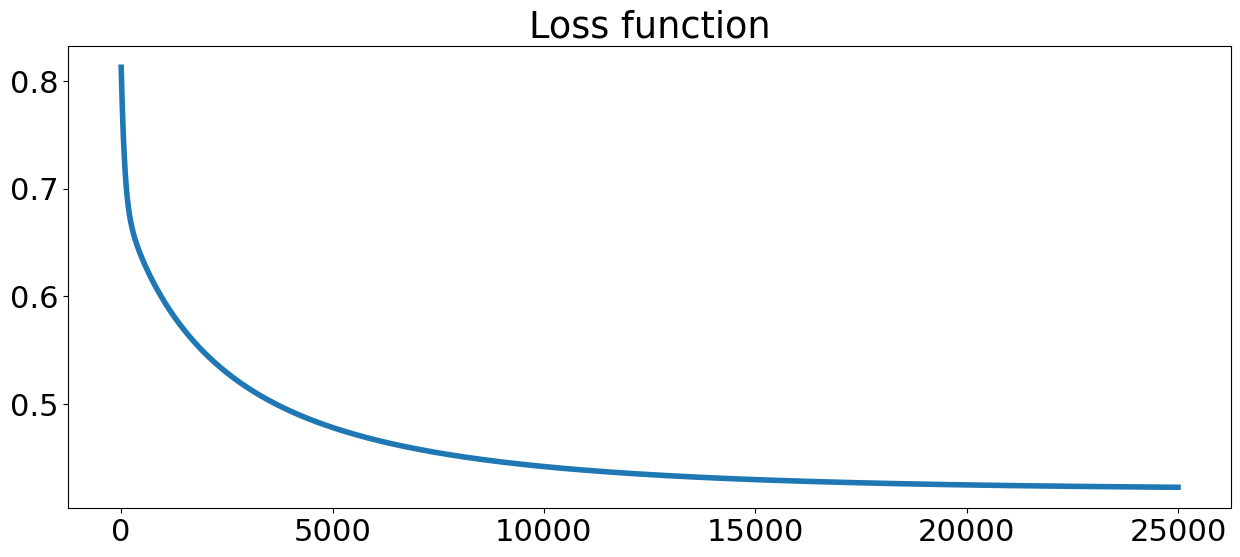

In [131]:
plt.subplots(figsize=(15, 6))
plt.plot(J_histoty, label='Loss function', linewidth=4)
plt.title("Loss function");

### Метрики качества классификации

In [118]:
new_p = predicted_p(mapped_X, new_w, new_b)
print("\n",  "**" * 38,  "\n")
print('Train Accuracy: %f'%(np.mean(new_p == yy_train) * 100))
print("\n",  "**" * 38,  "\n")
print(classification_report(yy_train, new_p))
print("\n",  "**" * 38,  "\n")


 **************************************************************************** 

Train Accuracy: 82.203390

 **************************************************************************** 

              precision    recall  f1-score   support

         0.0       0.88      0.75      0.81        60
         1.0       0.78      0.90      0.83        58

    accuracy                           0.82       118
   macro avg       0.83      0.82      0.82       118
weighted avg       0.83      0.82      0.82       118


 **************************************************************************** 



### Построение границы принятия решения

In [132]:
def plot_decision_boundary(w, b) -> None:
    """
    Функция, которая рисует границу решения для логистической регрессии.
    
    Args:
      w : (ndarray (n,)) :      Вектор весов модели 
      b : (scalar) :            Смещение модели 
    
    Return:
      None
    """
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)
    z = np.zeros((len(u), len(v)))
    
    # Для каждой пары значений из u и v заполняем массив z значением сигмоиды
    for i in range(len(u)):
        for j in range(len(v)):
            new_features = map_feature(u[i], v[j])
            z[i, j] = sigmoid(np.dot(new_features, w) + b)
    z = z.T
    
    # Строим контурный график с уровнем 0.5 зеленым цветом
    plt.contour(u,v,z, levels=[0.5], colors="g")

    return None



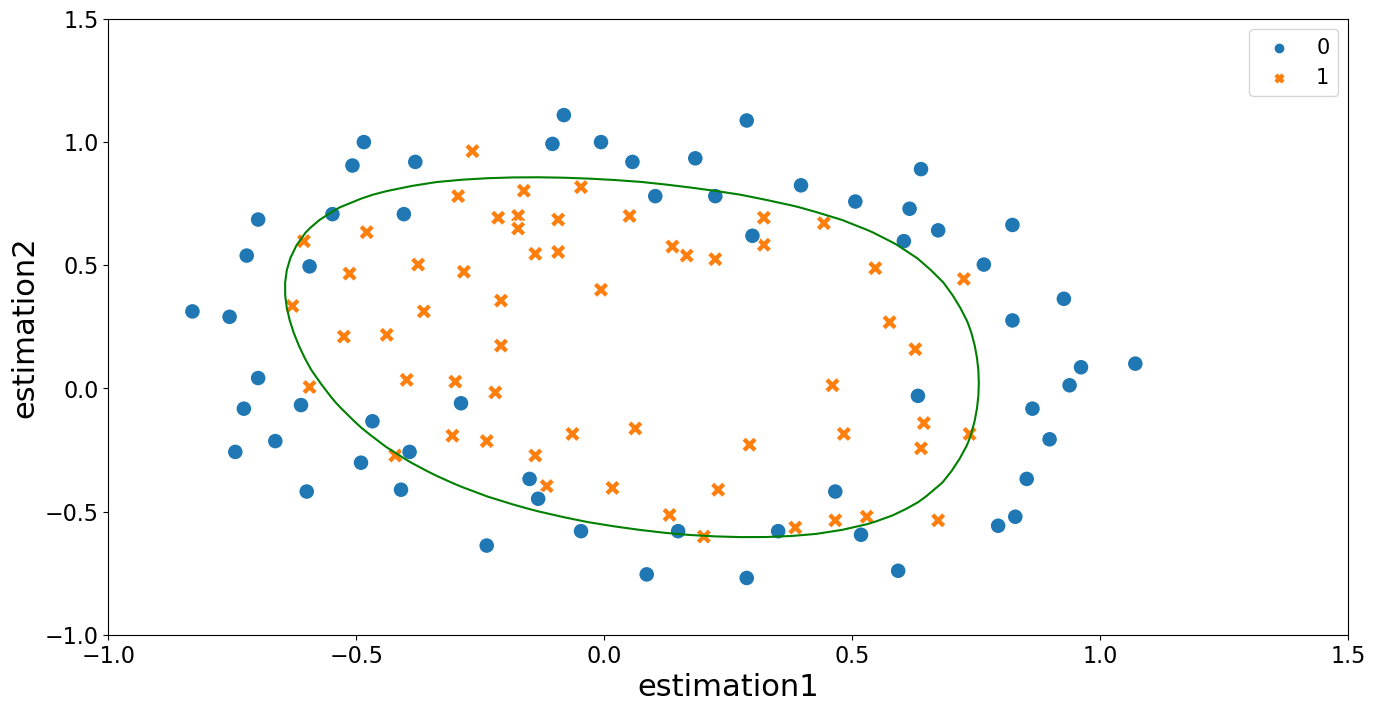

In [133]:
plt.figure(figsize= (16, 8))
sns.scatterplot(
    x = "estimation1",
    y = "estimation2",
    hue = "Y",
    data = df2,
    s = 130,
    style="Y",
)
plt.tick_params(labelsize = 16)
plt.legend(fontsize = 15);
plot_decision_boundary(new_w, new_b);

---

## Полиномиальная логистическая регрессия с регуляризацией гребня scikit-learn



In [92]:
X_train_set, X_test_set, y_train_set, y_test_set = train_test_split(
    mapped_X,
    yy_train,
    test_size=.2,
    random_state=1234
)

###  Обучение

In [93]:
logreg = RidgeClassifierCV()
logreg.fit(X_train_set, y_train_set)
Y_pred = logreg.predict(X_test_set)

RidgeClassifierCV()

In [134]:
print("\n",  "**" * 38,  "\n")
print('Точность на тестовом сете: {:.2f}'.format(logreg.score(X_test_set, y_test_set) * 100))
print("\n",  "**" * 38,  "\n")
print(classification_report(y_test_set, Y_pred))
print("\n",  "**" * 38,  "\n")


 **************************************************************************** 

Точность на тестовом сете: 83.33

 **************************************************************************** 

              precision    recall  f1-score   support

         0.0       0.92      0.79      0.85        14
         1.0       0.75      0.90      0.82        10

    accuracy                           0.83        24
   macro avg       0.83      0.84      0.83        24
weighted avg       0.85      0.83      0.83        24


 **************************************************************************** 



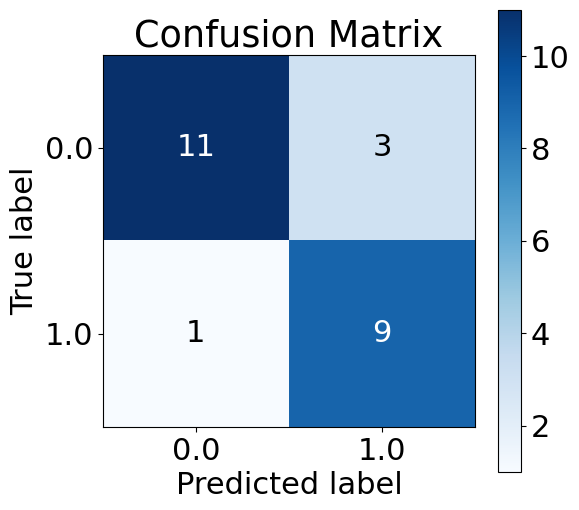

In [121]:
skplt.metrics.plot_confusion_matrix(
    y_test_set,
    Y_pred,
    figsize=(6, 6)
)
plt.show();

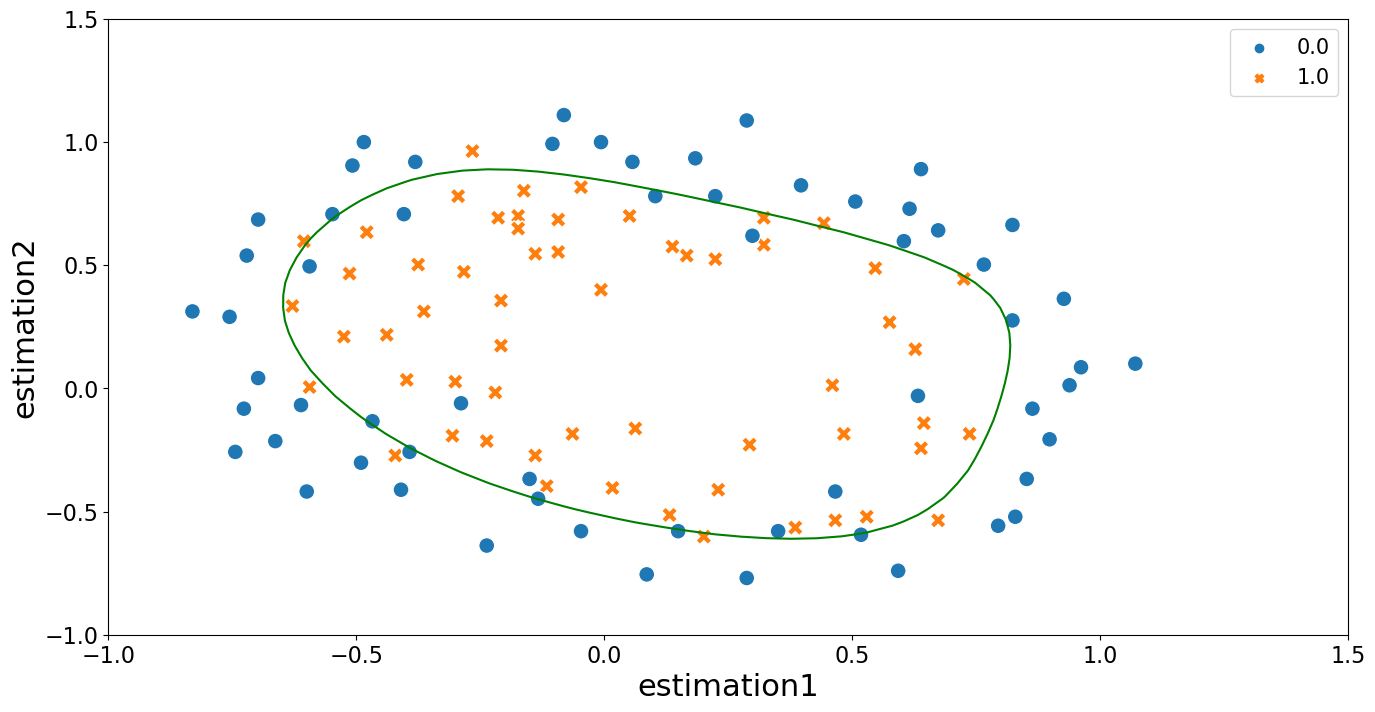

In [96]:
plt.figure(figsize=(16, 8))
sns.scatterplot(
    x="estimation1",
    y="estimation2",
    hue="Y",
    data=df2,
    s=130,
    style="Y",
)
plt.tick_params(labelsize=16)
plt.legend(fontsize=15);
plot_decision_boundary(logreg.coef_.ravel(), logreg.intercept_);

---

# Выводы

In [97]:
test_df = pd.DataFrame(
    zip(
        yy_train,
        logreg.predict(mapped_X), 
        new_p
    ),
    columns=['Class', 'Model_Sklearn', 'Model_Numpy']
)



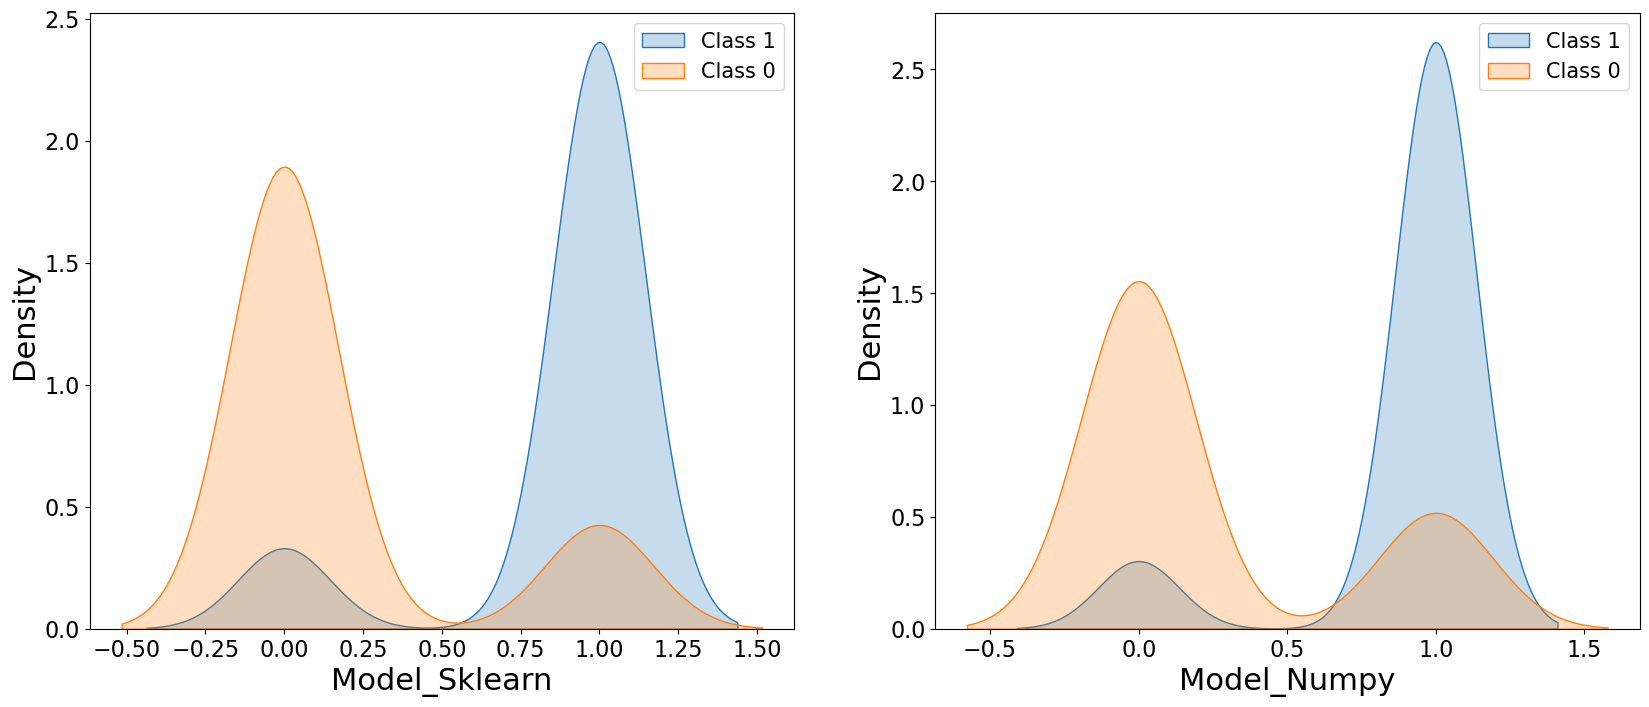

In [98]:
cols = ['Model_Sklearn', 'Model_Numpy']


fig, axs = plt.subplots(1, 2, figsize=(20, 8))
plt.rc('font', size=22)

# Для каждой колонки строим график плотности распределения для двух классов
for index, col in enumerate(cols):
    # Строим график для класса 1
    sns.kdeplot(
        test_df[test_df['Class'] == 1][col],
        label="Class 1",
        shade=True,
        ax=axs[index]
    )
         
    # Строим график для класса 0
    sns.kdeplot(
        test_df[test_df['Class'] == 0][col],
        label="Class 0",
        shade=True,
        ax=axs[index]
    )
    
    axs[index].set_xlabel(col)
    

    axs[index].tick_params(labelsize=16)
    axs[index].legend(fontsize=15)

plt.show();



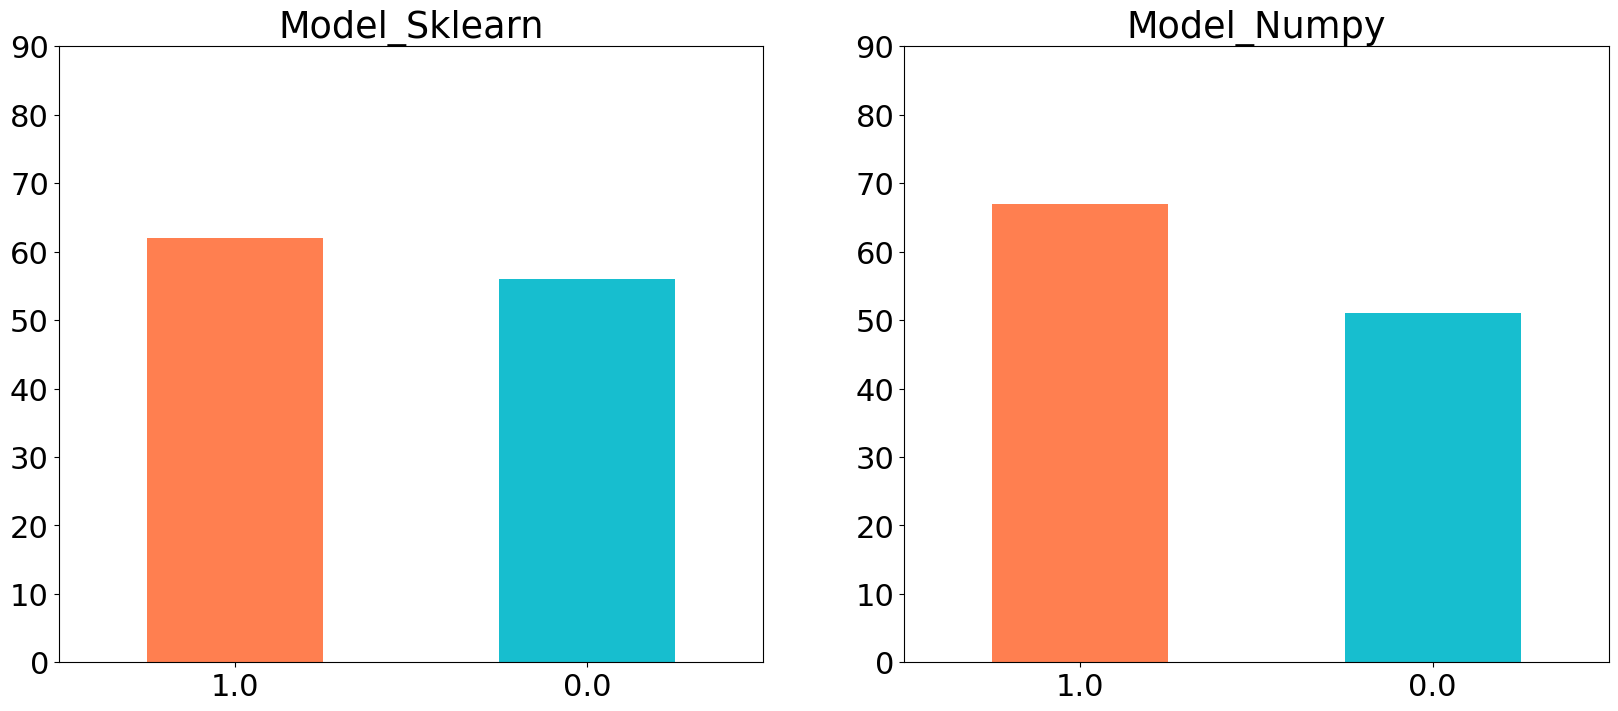

In [99]:
figur, axes = plt.subplots(1, 2, figsize=(20, 8))


kind = "bar"
color = ("coral", "tab:cyan")
rot = 360
ylim = (0, 90)

#  График для Model_Sklearn
test_df["Model_Sklearn"].value_counts().plot(
    ax=axes[0],
    kind=kind,
    color=color,
    rot=rot,
    title="Model_Sklearn",
    ylim=ylim
)

#  График для Model_Numpy
test_df["Model_Numpy"].value_counts().plot(
    ax=axes[1],
    kind=kind,
    color=color,
    rot=rot,
    title="Model_Numpy",
    ylim=ylim
)

plt.show();


___

**Скорее всего градиент расчитанный вручную застревает в седловых точках или локальных минимумах, поэтому результат хуже, чем у Sklearn**